In [1]:
import os
import platform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sb

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics

path = "."

originalDatasetFile = os.path.join(path, "Clean_Dataset.csv")
originalDataset = pd.read_csv(originalDatasetFile, index_col = 0)

# Sorting the results by airline in ascending order
originalDataset = originalDataset.sort_values(by = 'airline', ascending = True)

# Dropping the flight column as it's not important for modelling
originalDataset.drop('flight', 1, inplace = True)

# Converting the price from Indian rupees to GBP
originalDataset['price'] = (originalDataset["price"]*0.011).round(2)

# Print the dataset
print(originalDataset)

        airline source_city departure_time        stops arrival_time  \
184894  AirAsia     Chennai          Night          one      Morning   
186660  AirAsia     Chennai        Morning  two_or_more   Late_Night   
186659  AirAsia     Chennai        Morning          one   Late_Night   
186658  AirAsia     Chennai        Morning  two_or_more        Night   
186657  AirAsia     Chennai        Morning          one        Night   
...         ...         ...            ...          ...          ...   
211524  Vistara       Delhi        Evening          one        Night   
87243   Vistara   Bangalore        Evening          one   Late_Night   
87244   Vistara   Bangalore        Morning          one    Afternoon   
87482   Vistara   Bangalore        Morning          one      Evening   
300152  Vistara     Chennai        Morning          one      Evening   

       destination_city     class  duration  days_left   price  
184894            Delhi   Economy     10.92         33   27.25  
18666

C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\1894303865.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  originalDataset.drop('flight', 1, inplace = True)


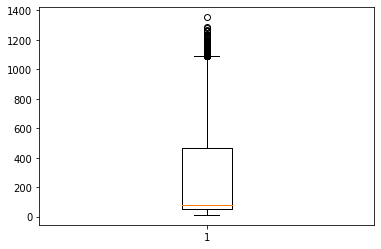

airline             False
source_city         False
departure_time      False
stops               False
arrival_time        False
destination_city    False
class               False
duration            False
days_left           False
price               False
dtype: bool


In [2]:
#Valli's code - further cleanup of the data (feature engineering)

plt.boxplot(originalDataset['price'])
plt.show()

print(originalDataset.isnull().any())

In [3]:
## Valli's code
#creates a new column in the dataframe named 'price outlier'
originalDataset['price_outlier'] = 0

#to find the mean and standard deviation of the price values to work out the outlier
price_mean = np.mean(originalDataset['price'])
print(price_mean)
price_std = np.std(originalDataset['price'])
print(price_std)

#calculation to assign 0 or 1 to the price values (0 if the datapoint is not an outlier & 1 if it is)
originalDataset.loc[abs(originalDataset['price'] - price_mean) > 2 * price_std,'price_outlier'] = 1

#This counts the number of unique outlier values
print(Counter(originalDataset['price_outlier']))

originalDataset = originalDataset[originalDataset.price_outlier != 1]
print (originalDataset.shape)

# Dropping the price outlier column as it may affect the final model results
originalDataset.drop('price_outlier', 1, inplace = True)

229.78609928936243
249.67505500334298
Counter({0: 289222, 1: 10931})
(289222, 11)


C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2854553718.py:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  originalDataset.drop('price_outlier', 1, inplace = True)
C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2854553718.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  originalDataset.drop('price_outlier', 1, inplace = True)


In [4]:
#Aakash's code
le = LabelEncoder()

# Label encoding to ensure the dataset does not contain any string values
originalDataset['airline'] = le.fit_transform(originalDataset['airline'])
originalDataset['source_city'] = le.fit_transform(originalDataset['source_city'])
originalDataset['departure_time'] = le.fit_transform(originalDataset['departure_time'])
originalDataset['arrival_time'] = le.fit_transform(originalDataset['arrival_time'])
originalDataset['destination_city'] = le.fit_transform(originalDataset['destination_city'])
originalDataset['class'] = le.fit_transform(originalDataset['class'])

# Find unique values within the stops column
print(list(set(originalDataset['stops'])))

# Match and replace the numerical values in text with integers
originalDataset['stops'] = originalDataset['stops'].replace(["zero", "one", "two_or_more"], [0, 1, 2])

print(originalDataset.head())

C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2066078379.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  originalDataset['airline'] = le.fit_transform(originalDataset['airline'])
C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2066078379.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  originalDataset['source_city'] = le.fit_transform(originalDataset['source_city'])
C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2066078379.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

['two_or_more', 'one', 'zero']
        airline  source_city  departure_time  stops  arrival_time  \
184894        0            1               5      1             4   
186660        0            1               4      2             3   
186659        0            1               4      1             3   
186658        0            1               4      2             5   
186657        0            1               4      1             5   

        destination_city  class  duration  days_left  price  
184894                 2      1     10.92         33  27.25  
186660                 2      1     16.00         44  27.25  
186659                 2      1     15.17         44  27.25  
186658                 2      1     13.50         44  27.25  
186657                 2      1     11.67         44  27.25  


C:\Users\kinga\AppData\Local\Temp\ipykernel_7312\2066078379.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  originalDataset['stops'] = originalDataset['stops'].replace(["zero", "one", "two_or_more"], [0, 1, 2])


In [5]:
result = []
for x in originalDataset.columns:
    if x != 'price':
        result.append(x)
        
X = originalDataset[result].values
y = originalDataset['price'].values

model = LinearRegression()

In [6]:
# Using 5 k-fold cross validation

kf = KFold(5, shuffle = True, random_state = 44)

fold = 1

for train_index, validate_index in kf.split(X,y):
    model.fit(X[train_index],y[train_index])
    y_test = y[validate_index]
    y_pred = model.predict(X[validate_index])
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print(f"Fold #{fold}, Training Size: {len(X[train_index])}, Validation Size: {len(X[validate_index])}")
    fold += 1
    
print(model.coef_)

Root Mean Squared Error: 62.62894794183298
Fold #1, Training Size: 231377, Validation Size: 57845
Root Mean Squared Error: 62.6955524367246
Fold #2, Training Size: 231377, Validation Size: 57845
Root Mean Squared Error: 62.81122043307166
Fold #3, Training Size: 231378, Validation Size: 57844
Root Mean Squared Error: 62.0884104325112
Fold #4, Training Size: 231378, Validation Size: 57844
Root Mean Squared Error: 62.6820081671752
Fold #5, Training Size: 231378, Validation Size: 57844
[ 7.05220578e+00  3.75111063e-01  6.31487578e-01  5.71382412e+01
  7.64546510e-01  4.36466652e-01 -4.69234759e+02  1.07671273e+00
 -1.24471882e+00]


<AxesSubplot: title={'center': 'Linear Regression Model'}, xlabel='Actual', ylabel='Predicted'>

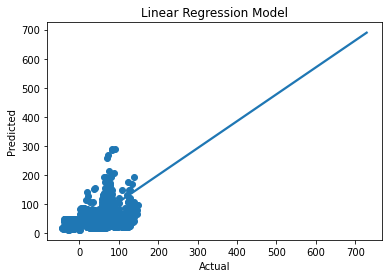

In [7]:
# Regression plot

plt.scatter(y_pred[:2000], y_test[:2000])
plt.title ("Linear Regression Model")
plt.xlabel('Actual')
plt.ylabel('Predicted')
sb.regplot(x = y_test, y = y_pred, scatter = False)

In [8]:
originalDataset_compare = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
originalDataset_head = originalDataset_compare.head(25)

print(originalDataset_head)

    Actual  Predicted
0    27.25  28.122116
1    66.09  76.493002
2    33.99  22.599934
3    33.99  23.813088
4    33.99  80.054597
5    33.99  22.427269
6    33.99  20.227796
7    39.26  83.588700
8    33.99  84.981674
9    33.99  84.260276
10   27.25  29.366835
11   65.33  74.621973
12   65.33  73.584475
13   89.22  83.819507
14   27.25  41.695828
15   33.99  23.671988
16   33.15  88.216125
17   33.15  20.637084
18   33.15  28.834388
19   27.25  26.522082
20   49.49 -40.363001
21   33.15  82.031860
22   33.15  27.320491
23   25.70  48.681096
24   25.70  51.519213


In [9]:
print('Mean:', np.mean(y_test))
print('Coefficient of determination: %.2f' % metrics.r2_score(y_test, y_pred))
print('Correlation: ', stats.pearsonr(y_test,y_pred))

Mean: 209.5159385588825
Coefficient of determination: 0.92
Correlation:  (0.9610480004786195, 0.0)
